In [1]:
import baltic as bt
from matplotlib import pyplot as plt
from collections import defaultdict
from matplotlib import cm
from numpy import linspace
%matplotlib inline
import json
import matplotlib.gridspec as gridspec
import math
from itertools import combinations
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
import math

/Library/Python/2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [37]:
def assign_genotype_attr(tree, mrcas):
    ''' Finds the most basal node with each genotype annotation, 
    propagates the genotype assignment to its monophyletic descendents'''
    
    for k in tree.Objects: # remove old annotations
        k.traits = { key:value for key,value in k.traits.items() if key!='genotype' and k!='clade_name'}
        
    for genotype, node in mrcas.items():
        node.traits['genotype_mrca'] = True
        node.traits['genotype'] = genotype
        for child in tree.traverse_tree(node, include_all=True):
            if 'genotype' in child.traits:
                if genotype != child.traits['genotype']:
                    print 'ERROR: Overlapping genotypes %s and %s at index %s'%(child.traits['genotype'], genotype, child.index)
            child.traits['genotype'] = genotype
    return tree

def load_tree_find_mrcas(path = '../../data/frequencies/dengue_all_tree.json'):    
    tree = bt.loadJSON(path) ## baltic Tree object
    mrcas = { node.traits['clade_name']: node for node in tree.Objects if 'clade_name' in node.traits
            and node.traits['clade_name'] != 'DENV2_AMERICAN'}
    tree = assign_genotype_attr(tree, mrcas)
    return {'tree': tree, 'mrcas': mrcas}

def load_genotype_counts(mrcas, tree):
    '''
    {'frequencies': 
        {'south_america': 
            {'denv2_american': [ 0.1, 0.4, 0.23, ....]},
        }, 
    'pivots': [1900, 1901, ...]
    'genotypes': set('DENV2_AMERICAN', ...)
    }
    '''    
    dates = [i.traits['num_date'] for i in tree.leaves]
    regions = list(set([i.traits['region'] for i in tree.leaves]))
    regions.append('global')
    min_date = min(dates)
    max_date = max(dates)
    pivots = np.arange(min_date, max_date, 0.25) # min tip date to max tip date in 3-month intervals
    pivot_ranges = zip(pivots[:-1], pivots[1:])
        
    counts = {}
    counts['pivots'] = pivots
    for region in regions:
        if region == 'global':
            genotype_tips = { g : tree.traverse_tree(mrca)
                             for g,mrca in mrcas.items()}
        else:
            genotype_tips = { g : [i for i in tree.traverse_tree(mrca) if i.traits['region'] == region]
                             for g,mrca in mrcas.items()}
    
        def count_tips(genotype, start, end):
            all_tips = [i for i in dates if i >= start and i < end]
            if len(all_tips) < 3:
                return None
            else:
                return float(len([i for i in genotype_tips[g] if i.traits['num_date'] >= start and i.traits['num_date'] < end]))
            
        counts[region] = {}
        
        for g in genotype_tips.keys():
            counts[region][g] = [count_tips(g, s, e) for (s,e) in pivot_ranges]

    return counts

def assign_genotype_colors(genotypes):
    ''' {'denv2/asianI': viridis[0], ...}'''
    cmaps = [cm.Blues, cm.Greens, cm.Purples, cm.Reds]
    color_dict = {}
    
    for i, sero in enumerate(['DENV1', 'DENV2', 'DENV3', 'DENV4']):
        cmap = cmaps[i]
        geno = sorted([ g for g in genotypes if g.startswith(sero)])
        cm_subsection = linspace(0.25, 0.75,len(geno))
        colors = [ cmap(g) for g in cm_subsection]
        color_dict.update({g:color for (g,color) in zip(geno, colors)})
    
    return color_dict


def make_dataframe(region, mindate = 1970):
    ''' dataframe with genotypes as columns, pivots as index, region-specific frequencies as values'''
    region_data = frequencies[region]
    df = pd.DataFrame(region_data, index=pivots)
    df = df.loc[df.index[df.index >= mindate]]
    return df

In [38]:
tmp = load_tree_find_mrcas()

# bt.tree with k.traits['genotype'] initially assigned by augur-inferred clade_name trait
tree = tmp['tree']

# {'DENV2_AMERICAN': <baltic node>}
mrcas = tmp['mrcas']

# ['denv2/american', 'denv1/I', ...]
genotypes = mrcas.keys()

counts = load_genotype_counts(mrcas, tree)
# {'south_america': 
#         {'denv2_american': [ (1900, 0.2), (1920, 0.26), ....]},
#     }                      

# [1917., 1918., ...]
pivots = counts.pop('pivots')

# ['south_america', 'southeast_asia']
regions = counts.keys()

# { 'southeast_asia': pd.DataFrame(columns=genotypes, index=pivots, values=frequencies)}
region_dfs = { region: pd.DataFrame(counts[region], index=pivots[:-1]) for region in regions }

# {'denv2/american': color}
colors = assign_genotype_colors(genotypes)


Tree height: 404.784340
Tree length: 8947.442480
annotations present

Numbers of objects in tree: 1611 (775 nodes and 836 leaves)



In [63]:
def plot_region_counts(region, dfs = region_dfs, date_range = None, pivots=pivots):
    plt.title(region)
    plt.xlabel('Year')
    plt.ylabel('Genotype Counts')

    c = dfs[region]
    if date_range:
        pivots = [i for i in pivots if i > date_range[0] and i < date_range[1]]
        c = c.ix[pivots]
    
    for genotype, counts in c.iteritems():
        valid_pivots = [x for (x,y) in zip(pivots, counts) if not np.isnan(y)]
        valid_counts = [y for y in counts if not np.isnan(y)]
        plt.plot(valid_pivots, valid_counts, color=colors[genotype], label=genotype)   
    
def plot_tree():
    branchWidth=2 ## default branch width
    ll = tree
    xmax = max([k.absoluteTime for k in ll.Objects]) + 0.25

    plt.yticks(size=0)
    
    for k in ll.Objects: ## iterate over objects in tree
        x=k.absoluteTime ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        c = colors[k.traits['genotype']] if k.traits.has_key('genotype') else 'gray'

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            s=50 ## tip size can be fixed
            s=50-30*k.height/ll.treeHeight

            plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            if 'genotype_mrca' in k.traits:
                plt.text(xmax, y, k.traits['genotype'], zorder=100)
                plt.text(x,y, k.index, ha='right', zorder=100)
                plt.text(k.parent.absoluteTime, k.parent.y, k.parent.index, ha='right')
            plt.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
    x0,x1 = plt.xlim()
    plt.xlim((x0, x1*1.1))


def plot_counts_and_tree():
    sns.set(style='whitegrid', font_scale = 1.3)
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(11,8.5))
    gs = gridspec.GridSpec(3,3, width_ratios=[1,1,2], )
    
    globe = plt.subplot(gs[0, :-1])
    plot_region_counts('global', date_range=(1985., 1995.))
    plt.legend(loc=(2.5,-0.1), title="Dengue Genotypes", fontsize='large')

    south_america = plt.subplot(gs[1,:-1])
    plot_region_counts('south_america', date_range=(1985., 1995.))
    
    southeast_asia = plt.subplot(gs[2, :-1])
    plot_region_counts('southeast_asia', date_range=(1985., 1995.))
        
    sns.set(style = 'white', font_scale = 1.3)
    treeplot = plt.subplot(gs[:,-1])
    plot_tree()
        
    plt.tight_layout()
    plt.show()

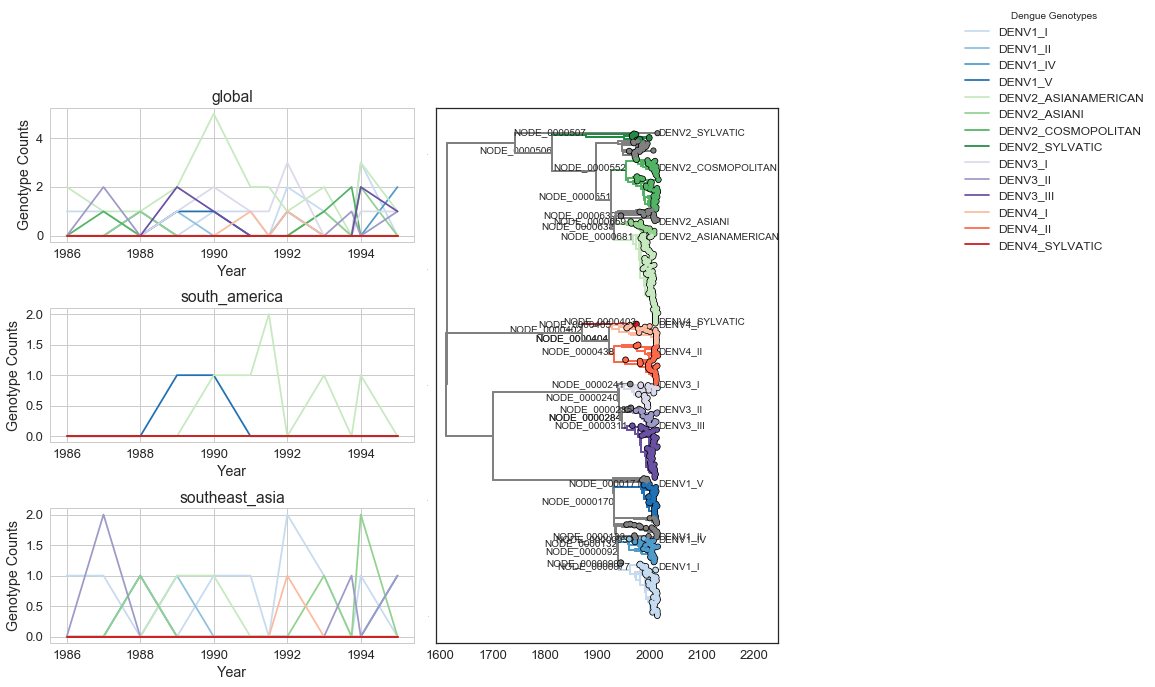

In [64]:
plot_counts_and_tree()

In [55]:
# def define_seasons(pivots, mindate=1970):
#     '''Returns tuples of numdates for 
#     May - December dengue seasons for each year in pivots'''
#     min_year = mindate if mindate else int(math.floor(min(pivots)))
#     max_year = int(math.ceil(max(pivots)))
#     seasons = [(year + 5./12., year + 364./365.) 
#                for year in range(min_year, max_year)]
#     return seasons #[(start, end), (start, end)]


# def find_hyperendemic_seasons(seasons, region):
#     '''
#     Return a subset of the data from seasons where there were >= 2 genotypes 
#     circulating in the region
#     '''
    
#     def bin_seasons(numdate):
#         ''' Return (start, end) season numdate belongs in'''
#         season = np.nan
#         for start, end in seasons:
#             if numdate >= start and numdate<= end:
#                 season = (start, end)
#                 break
#         return season

#     def is_hyperendemic(subset):
#         ''' Return boolean of whether there were >2 genotypes 
#         at >= 5% frequency on average during that season'''
#         mean_frequencies = subset.mean()
#         above_five_percent = mean_frequencies[mean_frequencies >= 0.05]
#         return len(above_five_percent) >= 2 ## return boolean
#         print above_five_percent
    
#     df = region_dfs[region]
#     these_pivots = df.index
#     df['season'] = these_pivots.map(bin_seasons)
    
#     hyperendemic_seasons = []
    
#     for season in seasons:
#         if is_hyperendemic(df.loc[df['season'] == season]):
#             hyperendemic_seasons.append(season)
    
#     hyperendemic_frequencies = df.loc[df['season'].isin(hyperendemic_seasons)]
#     return hyperendemic_frequencies

In [56]:
# seasons = define_seasons(pivots)

# hyperendemic_frequencies = {}
# for region in regions:
#     hyperendemic_frequencies[region] = find_hyperendemic_seasons(seasons, region)

In [57]:
# def are_intraserotype(genotype1, genotype2):
#     return genotype1.split('_')[0] == genotype2.split('_')[0]

# def intra_inter_serotype_pairs(freqs, min_frequency = 0.05):
#     ''' Takes row from genotype frequencies dataframe,
#     finds all genotypes above min_frequency at this time point, 
#     returns proportion of all pairs of cocirculating genotypes that are from the same serotype'''
#     above_min_frequency = freqs[freqs >= 0.05]
#     cocirculating_genotypes = above_min_frequency.index.values
#     pairs = [i for i in combinations(cocirculating_genotypes, 2)]
    
#     n_intraserotype_pairs = 0.
#     for genotype1, genotype2 in pairs:
#         if are_intraserotype(genotype1, genotype2):
#             n_intraserotype_pairs += 1.
            
#     total_pairs = float(len(pairs))
#     return n_intraserotype_pairs / total_pairs

# def map_intra_inter_serotype_pairs(df):
#     proportion_intraserotype = df.apply(intra_inter_serotype_pairs, axis=1)
#     mean_proportion_intraserotype = proportion_intraserotype.mean()
#     return mean_proportion_intraserotype

# def shuffle_labels(df):
#     shuffled = df.copy()
#     np.random.shuffle(shuffled.columns.values)
#     return shuffled

In [58]:
# def cocirculating(region, n = 1000):
#     data = hyperendemic_frequencies[region].groupby('season').agg('mean')

#     c = map_intra_inter_serotype_pairs(data)

#     null_distribution = []
#     for i in range(n):
#         shuffled_data = shuffle_labels(data)
#         null_distribution.append(map_intra_inter_serotype_pairs(shuffled_data))
    
#     return {'c': c, 'null_distribution': null_distribution}

In [59]:
# # cocirculating_in_south_america = cocirculating('south_america')

# cocirculating_in_southeast_asia = cocirculating('southeast_asia')
# c = cocirculating_in_southeast_asia['c']
# null = cocirculating_in_southeast_asia['null_distribution']

In [60]:
# sns.set_style('whitegrid')
# cocirculating_plot = sns.kdeplot(pd.Series(null))
# cocirculating_plot.plot([c for i in range(10)], [i for i in range(10)])
# cocirculating_plot.set_xlabel('Proportion of cocirculating genotypes from the same serotype')